In [ ]:
# https://towardsdatascience.com/how-to-perform-exploratory-data-analysis-with-seaborn-97e3413e841d

### Index

1. [x] 관련내용 설치
2. [x] 자료 불러오기
  + [ ] 표준포멧 : 내용정의/확인
  + [ ] 자료결합 : 채용자료 및 평가자료(ex. 사번 기준)
3. [x] 자료 전처리
  + [ ] 평가내용 : 맞춤법 검사
  + [ ] 등급자료 : 수치화(ex. S등급 : 5점 / D 등급 : 1점)
  + [ ] 등급자료 : n년치 자료에 대한 평균계산 
  + [ ] 연차자료 : 수치화(ex. 1년2개월 : 1.167 년)
4. [ ] EDA
5. 주요 가설 검정(code 삭제/정렬 예정)
  1. [x] 인적성 시행여부와 평가결과의 관계
  2. [ ] 채용 절차 준수여부와 평가결과의 관계
  3. [ ] 추천 채용과 평가결과의 상관관계
  4. [ ] 저평가의 주요 사유
  5. [ ] 저평가자의 평균 근속
  6. [ ] 3년 미만 저평가자 비율


### 1.관련내용 설치

In [3]:
import warnings
warnings.filterwarnings(action='ignore') 

In [1]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

Selecting previously unselected package fonts-nanum.
(Reading database ... 155629 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs

In [2]:
exit()

In [5]:
!pip install -U pandas-profiling -qqq
!pip install torch --upgrade -qqq
!pip install Pororo -qqq
!pip install git+https://github.com/ssut/py-hanspell.git
!pip install sentence_transformers -qqq
!pip install customized_konlpy -qqq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-fiwtuw34
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-fiwtuw34
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4868 sha256=c22bfc8512f2089a9711a186ce529b12b16e66f3f610503613010660d6f8a114
  Stored in directory: /tmp/pip-ephem-wheel-cache-7jonyvsu/wheels/ab/f5/7b/d4124bb329c905301baed80e2ae45aa14e824f62ebc3ec2cc4
Successfully built py-hanspell
     |████████████████████████████████| 881 kB 5.5 MB/s 
     |████████████████████████████████| 453 kB 62.6 MB/s 
     |████████████████████████████████| 19.4 MB 1.2 MB/s 


In [20]:
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

import numpy as np
import itertools
import pandas as pd
from tqdm import trange

# 한글정제 KoNLPy
from ckonlpy.tag import Twitter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import nltk

from hanspell import spell_checker


NanumBarunGothic


In [27]:
df1 = pd.read_excel('./data_20220519_v2.xlsx',0)
df2 = pd.read_excel('./data_20220519_v2.xlsx',1)
# new_header = df.iloc[0] #grab the first row for the header
# df = df[1:] #take the data less the header row
# df.columns = new_header #set the header row as the df header

### 2.데이터 전처리

In [ ]:
# 채용자료/평가자료 결합 : 사번 기준

#### A.맞춤법 검사

In [29]:
array_text_ = list(df2.평가근거)
array_text_2 = []

for i in trange(len(array_text_)):
    try:
        spelled_sent = spell_checker.check(array_text_[i])
        hanspell_sent = spelled_sent.checked
        array_text_2.append(hanspell_sent)
    except:
        array_text_2.append('')


100%|██████████| 613/613 [00:48<00:00, 12.64it/s]


In [30]:
df2['평가근거_수정'] = array_text_2

#### B.내용 분류1
 : zero-topic

In [9]:
# 평가내용 분류
from pororo import Pororo
zsl = Pororo(task="zero-topic", lang="ko")

In [31]:
reason_list = ['개인태도', '직무역량', '휴직', '문제없음']

array_text_ = list(df2.평가근거)
reason_1st = []
reason_row = []
for i in trange(len(array_text_)):
    try:
        temp = zsl(array_text_[i], reason_list)
        reason_row.append(temp)
        reason_1st.append(max(temp, key=temp.get))
    except:
        reason_row.append('')
        reason_1st.append('')

100%|██████████| 613/613 [02:29<00:00,  4.10it/s]


In [32]:
df2['평가근거_구분'] = reason_1st
df2['평가근거_구분상세'] = reason_row

In [36]:
reason_list = ['태도', '직무능력']

array_text_ = list(df1.최종선발사유)
reason1_1st = []
reason1_row = []
for i in trange(len(array_text_)):
    try:
        temp = zsl(array_text_[i], reason_list)
        reason1_row.append(temp)
        reason1_1st.append(max(temp, key=temp.get))
    except:
        reason1_row.append('')
        reason1_1st.append('')

100%|██████████| 216/216 [00:57<00:00,  3.73it/s]


In [37]:
df1['최종선발사유_구분'] = reason1_1st
df1['최종선발사유_구분상세'] = reason1_row

#### C.내용 분류2 : token화
+ 필요한 단어만 추출하고자 할 경우(?)
+ 주요 Text 내용를 보고자 하는 경우 

In [38]:
###############
# Text 정제
#####

twitter = Twitter()

# 사전에 고유 명사 추가
twitter.add_dictionary('상대적', 'Noun')
twitter.add_dictionary('절대적', 'Noun')
twitter.add_dictionary('지속적', 'Noun')
twitter.add_dictionary('수동적', 'Noun')
twitter.add_dictionary('소극적', 'Noun')
twitter.add_dictionary('부정적', 'Noun')
twitter.add_dictionary('자발적', 'Noun')
twitter.add_dictionary('방어적', 'Noun')
twitter.add_dictionary('파트장', 'Noun')
twitter.add_dictionary('입사', 'Noun')
twitter.add_dictionary('상대평가', 'Noun')
twitter.add_dictionary('크로네스', 'Noun')
twitter.add_dictionary('숙련도', 'Noun')
twitter.add_dictionary('안전사고', 'Noun')
twitter.add_dictionary('생산성', 'Noun')
twitter.add_dictionary('검사원', 'Noun')

twitter.add_dictionary('지원팀', 'Noun')
twitter.add_dictionary('전환배치', 'Noun')
twitter.add_dictionary('지속성', 'Noun')
twitter.add_dictionary('부족', 'Noun')
twitter.add_dictionary('액상', 'Noun')
twitter.add_dictionary('입사', 'Noun')

twitter.add_dictionary('초창기', 'Noun')
twitter.add_dictionary('근태', 'Noun')
twitter.add_dictionary('태도', 'Noun')
twitter.add_dictionary('자세', 'Noun')

twitter.add_dictionary('클레임', 'Noun')
twitter.add_dictionary('불이행', 'Noun')
twitter.add_dictionary('기술력', 'Noun')
twitter.add_dictionary('정교함', 'Noun')

twitter.add_dictionary('입사', 'Noun')
twitter.add_dictionary('공방', 'Noun')
twitter.add_dictionary('트러블', 'Noun')

/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [142]:
tokenized_text = []
array_text_ = list(df2.평가근거)

for i in trange(len(array_text_)):
    try:
        tokenized_doc = twitter.pos(array_text_[i], norm=True, stem=True)
        # tokenized_nouns = ' '.join([word[0] for word in tokenized_doc if (word[1] == 'Noun') | (word[1] == 'Verb') | (word[1] == 'Adjective')])
        tokenized_nouns = [word[0] for word in tokenized_doc if (word[1] == 'Noun') | (word[1] == 'Verb') | (word[1] == 'Adjective')]
        tokenized_text.append(tokenized_nouns)
    except:
        tokenized_text.append('')

100%|██████████| 613/613 [00:00<00:00, 1023.83it/s]


In [168]:
list(df2.평가근거)[:2]

['21년 10월 사내 흡연 건으로 징계(감봉) 이력',
 '최소한의 기본 업무만 진행하고 교대 시간 임박한 대의 검사 업무는 다음직으로 미루는 경우 발생']

In [169]:
tokenized_text[:2]

[['사내', '흡연', '건', '징계', '감봉', '이력'],
 ['최소한',
  '기본',
  '업무',
  '진행',
  '교대',
  '시간',
  '임박',
  '대의',
  '검사',
  '업무',
  '다음',
  '직',
  '미루다',
  '경우',
  '발생']]

In [186]:
df2['평가근거_tokne'] = tokenized_text

In [181]:
from collections import Counter
word = sum(list(set(df2['평가근거_tokne'])), [])
vocab = Counter(word)

TypeError: ignored

In [167]:
vocab.most_common(20)

[('업무', 144),
 ('부족', 91),
 ('문제', 48),
 ('등급', 47),
 ('없다', 45),
 ('역량', 44),
 ('평가', 43),
 ('근무', 42),
 ('낮다', 34),
 ('동료', 32),
 ('인하다', 32),
 ('및', 32),
 ('능력', 32),
 ('함', 30),
 ('되다', 26),
 ('특별', 25),
 ('조정', 25),
 ('부여', 24),
 ('수행', 24),
 ('상대평가', 24)]

#### D.등급자료 변환

In [ ]:

# 평가결과 수치화
df['19년']= df['19년'].replace('S', 5).replace('A', 4).replace('B', 3).replace('C', 2).replace('D', 1)
df['20년']= df['20년'].replace('S', 5).replace('A', 4).replace('B', 3).replace('C', 2).replace('D', 1)
df['21년']= df['21년'].replace('S', 5).replace('A', 4).replace('B', 3).replace('C', 2).replace('D', 1)
df['19년'] = pd.to_numeric(df['19년'])
df['20년'] = pd.to_numeric(df['20년'])
df['21년'] = pd.to_numeric(df['21년'])

df['21년']  = df['21년'].fillna(2)


df['인적성 시행유무']= df['인적성 시행유무'].str.lower()

In [ ]:
df['3년_평균'] = (df['19년'] + df['20년'] + df['21년'])/3

#### E.근무기간 자료 변환

(ex. 1년2개월  ->  1.167)


In [10]:
# 근무기간 수치화
df['그룹입사일_근무년'] = df['그룹입사일_근무년월'].str.split('년', expand=True)[0].astype('int')
df['그룹입사일_근무월'] = df['그룹입사일_근무년월'].str.split('년', expand=True)[1]
df['그룹입사일_근무월'] = df['그룹입사일_근무월'].str.split('개월', expand=True)[0].astype('int')
df['근무기간_년'] = df['그룹입사일_근무년'] + df['그룹입사일_근무월']/12

NameError: ignored

#### 자료 저장

In [194]:


# Excel 자료 저장 v2
now = datetime.today() + timedelta(hours = 9 )    # 현재 in google
now = now.strftime('%Y-%m-%d')
now = datetime.strptime(now,'%Y-%m-%d')
date_ = now.strftime('%y%m%d')

writer = pd.ExcelWriter('./'+ date_ + '_kurly_review.xlsx')
df1.to_excel(writer, 'Sheet1')
writer.save()


'220524'

### 3.EDA

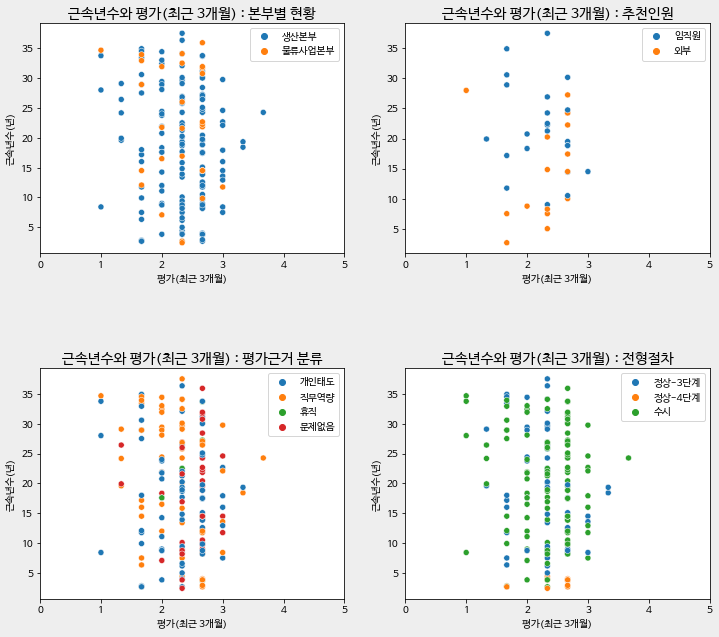

In [ ]:
fig = plt.figure(figsize=(12, 10), facecolor='#eeeeee' )

plt.subplot(2, 2, 1)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.5)
sns.scatterplot(x = '3년_평균', y ='근무기간_년', hue = '본부', data = df)
plt.legend(loc='best')
plt.title('근속년수와 평가(최근 3개월) : 본부별 현황',fontsize='x-large')
plt.ylabel('근속년수(년)'); plt.xlabel('평가(최근 3개월)')
plt.xlim([0,5])

plt.subplot(2, 2, 2)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.5)
sns.scatterplot(x = '3년_평균', y ='근무기간_년', hue = '추천자_구분', data = df)
plt.legend(loc='best')
plt.title('근속년수와 평가(최근 3개월) : 추천인원',fontsize='x-large')
plt.ylabel('근속년수(년)'); plt.xlabel('평가(최근 3개월)')
plt.xlim([0,5])

plt.subplot(2, 2, 3)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.5)
sns.scatterplot(x = '3년_평균', y ='근무기간_년', hue = '평가근거_구분', data = df)
plt.legend(loc='best')
plt.title('근속년수와 평가(최근 3개월) : 평가근거 분류',fontsize='x-large')
plt.ylabel('근속년수(년)'); plt.xlabel('평가(최근 3개월)')
plt.xlim([0,5])

plt.subplot(2, 2, 4)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.5)
sns.scatterplot(x = '3년_평균', y ='근무기간_년', hue = '전형절차_구분', data = df)
plt.legend(loc='best')
plt.title('근속년수와 평가(최근 3개월) : 전형절차',fontsize='x-large')
plt.ylabel('근속년수(년)'); plt.xlabel('평가(최근 3개월)')
plt.xlim([0,5])
plt.show()

### 5.주요 가설 검정

In [ ]:
#### A.[인적성] 시행 여부: 인적성 시행여부와 평가결과의 관계 확인

In [ ]:
df_t = df[['그룹입사일_근무년월', '19년','20년','21년', '인적성 시행유무']] 
df_t['인적성 시행유무'] = df_t['인적성 시행유무'].str.lower().fillna('x')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 1 to 216
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   그룹입사일_근무년월  216 non-null    object
 1   19년         198 non-null    object
 2   20년         199 non-null    object
 3   21년         213 non-null    object
 4   인적성 시행유무    216 non-null    object
dtypes: object(5)
memory usage: 8.6+ KB


In [ ]:
pd.pivot_table(df_t, values='그룹입사일_근무년월', index=['21년'],columns=['인적성 시행유무'],  aggfunc='count')

인적성 시행유무,o,x
21년,,
A,1.0,2.0
B,10.0,61.0
C,18.0,90.0
D,5.0,25.0
S,NaN,1.0


In [ ]:
pd.pivot_table(df_t, values='그룹입사일_근무년월', index=['20년'],columns=['인적성 시행유무'],  aggfunc='count')

인적성 시행유무,o,x
20년,,
A,NaN,4.0
B,6.0,60.0
C,15.0,88.0
D,3.0,23.0


In [ ]:
pd.pivot_table(df_t, values='그룹입사일_근무년월', index=['19년'],columns=['인적성 시행유무'],  aggfunc='count')

인적성 시행유무,o,x
19년,,
A,1.0,11.0
B,10.0,78.0
C,7.0,69.0
D,NaN,20.0
S,NaN,2.0


In [ ]:
#### B.[채용 절차] 준수 여부
# - 가설 : 저 평가자는 [채용 절차]를 준수하지 않았을 것이다
# - 확인 : 정상적인 [채용 절차]란?

In [ ]:
df2 = df[['그룹입사일_근무년월', '19년','20년','21년', '전형절차', '인적성 시행유무', '최종 면접관', '최종선발사유', '추천자', '전형 자료보관 유무']].copy()

In [ ]:
df2['전형 자료보관 유무'] = df2['전형 자료보관 유무'].str.lower()
df2['전형 자료보관 유무'] = df2['전형 자료보관 유무'].fillna('x')
df2['전형 자료보관 유무'] = df2['전형 자료보관 유무'].replace('○', 'o')

1    o
Name: 전형 자료보관 유무, dtype: object

In [ ]:
pd.pivot_table(df2, values='그룹입사일_근무년월', index=['전형절차'],columns=['21년'],  aggfunc='count')

21년,A,B,C,D,S
전형절차,,,,,
1년 계약후 정규직 전환,NaN,1.0,1.0,NaN,NaN
계약직 평가 후 정규직 전환면접,NaN,1.0,3.0,NaN,NaN
공고 /서류전형 /면접,1.0,5.0,1.0,1.0,NaN
공고-서류전형-1차면접,NaN,7.0,7.0,1.0,1.0
공고-서류전형-면접,NaN,6.0,22.0,4.0,NaN
공고-서류전형-인성-1차면접,NaN,2.0,5.0,1.0,NaN
공고-서류전형-인성검사-1차면접-2차면접,NaN,1.0,NaN,NaN,NaN
공고-서류전형-인성검사-면접,NaN,NaN,1.0,1.0,NaN
공고-서류전형-인적성-1차면접,1.0,5.0,1.0,NaN,NaN


In [ ]:
pd.pivot_table(df2, values='그룹입사일_근무년월', index=['전형 자료보관 유무'],columns=['21년'],  aggfunc='count')

21년,A,B,C,D,S
전형 자료보관 유무,,,,,
o,NaN,18.0,42.0,9.0,NaN
x,3.0,47.0,63.0,21.0,NaN
○\n(면접조서),NaN,3.0,3.0,NaN,1.0
○\n(면접평가표),NaN,1.0,NaN,NaN,NaN
○\n(채용기안지),NaN,1.0,NaN,NaN,NaN
"○\n(채용기안지,면접평가표)",NaN,1.0,NaN,NaN,NaN


In [ ]:
#### C.[추천 채용]과 평가결과
# : 추천 채용과 평가결과의 상관관계 -> [추천 채용] 항목은 수치화가 불가하므로, 상관관계보다는 추천 여부와 저평가 비율로 변경함

In [ ]:
df3 = df[['그룹입사일_근무년월', '19년','20년','21년', '추천자', '전형 자료보관 유무']].copy()

In [ ]:
df3.추천자 = df3.추천자.fillna('0')
df3.추천자.unique()

array(['0', '정병동(파트장)', '김경석', '이상돌(분유팀원)', '학교장 추천', '한낙녕(공무팀원)',
       '홍춘원(생산과장)', '전)봉하천이사 추천', '매일유업강남진', '이계동 기사', '식당근무자추천', '유기식',
       '인력개발원', '곽길현', '김한중', '정종원', '박원기 ', '정상길', '보훈청', '대진냉동 김병휘 ',
       '광주직업훈련원', '나승국', '장승관', '낙농육우협회지인', '성진', '정보지', '석진석', '김금수',
       '학과교수', '인근지역 거주 주민', '공고 모집', '상록개발'], dtype=object)

In [ ]:
df3[df3['추천자'] != 0]['추천자'] = 1

In [ ]:
df3.추천자.unique()

array(['0', '정병동(파트장)', '김경석', '이상돌(분유팀원)', '학교장 추천', '한낙녕(공무팀원)',
       '홍춘원(생산과장)', '전)봉하천이사 추천', '매일유업강남진', '이계동 기사', '식당근무자추천', '유기식',
       '인력개발원', '곽길현', '김한중', '정종원', '박원기 ', '정상길', '보훈청', '대진냉동 김병휘 ',
       '광주직업훈련원', '나승국', '장승관', '낙농육우협회지인', '성진', '정보지', '석진석', '김금수',
       '학과교수', '인근지역 거주 주민', '공고 모집', '상록개발'], dtype=object)

In [ ]:
df3

,그룹입사일_근무년월,19년,20년,21년,추천자,전형 자료보관 유무
1,36년4개월,B,C,C,0,O
2,34년11개월,C,D,C,정병동(파트장),O
3,34년5개월,C,D,B,0,O
4,23년9개월,C,C,C,0,O
5,2년10개월,B,D,D,0,O
...,...,...,...,...,...,...
212,2년5개월,B,C,C,0,O
213,32년11개월,C,C,D,0,X
214,30년9개월,B,B,C,0,X
215,34년1개월,C,B,C,0,X


In [ ]:
pd.pivot_table(df3, values='그룹입사일_근무년월', index=['추천자'],columns=['21년'],  aggfunc='count')

21년,A,B,C,D,S
추천자,,,,,
0,3.0,60.0,84.0,24.0,1.0
공고 모집,NaN,NaN,4.0,1.0,NaN
곽길현,NaN,NaN,1.0,NaN,NaN
광주직업훈련원,NaN,1.0,1.0,NaN,NaN
김경석,NaN,1.0,NaN,NaN,NaN
김금수,NaN,NaN,1.0,NaN,NaN
김한중,NaN,NaN,1.0,NaN,NaN
나승국,NaN,1.0,NaN,NaN,NaN
낙농육우협회지인,NaN,NaN,1.0,NaN,NaN


In [ ]:
#### D.저평가의 주요 사유
# - 목적 : 평가 내용에 대해, 특정 분류로 지정한다 
# - 방법 : Zero-shot Topic Classification
# - 결론 : 인적성 없이 진행된 경우, [개인태도]에 문제되는 비율이 높은 것으로 확인됨 

In [ ]:
from pororo import Pororo
zsl = Pororo(task="zero-topic", lang="ko")

reason_list = ['개인태도', '직무역량', '휴직', '문제없음']

In [ ]:
print(list(df.평가근거)[15])
print(zsl(list(df.평가근거)[15], reason_list))

동일 직급 상대평가, 직급 대비 업무 전문성(숙련도) 낮음
{'개인태도': 43.43, '직무역량': 93.7, '휴직': 1.08, '문제없음': 3.1}


In [ ]:
print(list(df.평가근거)[188])
print(zsl(list(df.평가근거)[188], reason_list))

상대평가에 의한 평가로 생산성 문제없음.
{'개인태도': 7.24, '직무역량': 25.11, '휴직': 0.82, '문제없음': 97.45}


In [ ]:
print(list(df.평가근거)[154])
print(zsl(list(df.평가근거)[154], reason_list))

업무역량 부족(설비 이해도 및 설비 조작능력 저하로 휴먼에러 발생요인)
{'개인태도': 22.26, '직무역량': 30.1, '휴직': 55.09, '문제없음': 0.18}


In [ ]:
array_text_ = list(df.평가근거)
reason_1st = []
reason_row = []
for i in trange(len(array_text_)):
    try:
        temp = zsl(array_text_[i], reason_list)
        reason_row.append(temp)
        reason_1st.append(max(temp, key=temp.get))
    except:
        reason_.append('')

100%|██████████| 216/216 [02:07<00:00,  1.69it/s]


In [ ]:
df4 = df[['평가근거',  '개선 필요사항', '평가이후 F/U', '향후 조치의견(교육/전환 등)', '특이사항' ]].copy()
df4['평가근거_구분'] = reason_1st

In [ ]:
df4.groupby('평가근거_구분')['평가근거'].count()

평가근거_구분
개인태도    78
문제없음    48
직무역량    83
휴직       7
Name: 평가근거, dtype: int64

In [ ]:
df4['21년'] = df['21년']
df4['인적성 시행유무'] = df['인적성 시행유무'].str.lower()

In [ ]:
pd.pivot_table(df4, values='평가근거', index=['인적성 시행유무'],columns=['평가근거_구분'],  aggfunc='count').T

인적성 시행유무,o,x
평가근거_구분,,
개인태도,8,70
문제없음,5,43
직무역량,20,63
휴직,1,6


In [ ]:
#### E.저평가자 평균 근속
# : 저평가자의 평점과 근속연수간 상관관계

In [ ]:
df5 = df[['그룹입사일_근무년월', '공장', '19년','20년','21년']].copy()
df5['그룹입사일_근무년'] = df5['그룹입사일_근무년월'].str.split('년', expand=True)[0].astype('int')
df5['그룹입사일_근무월'] = df5['그룹입사일_근무년월'].str.split('년', expand=True)[1]
df5['그룹입사일_근무월'] = df5['그룹입사일_근무월'].str.split('개월', expand=True)[0].astype('int')

df5['19년']= df5['19년'].replace('S', 5).replace('A', 4).replace('B', 3).replace('C', 2).replace('D', 1)
df5['20년']= df5['20년'].replace('S', 5).replace('A', 4).replace('B', 3).replace('C', 2).replace('D', 1)
df5['21년']= df5['21년'].replace('S', 5).replace('A', 4).replace('B', 3).replace('C', 2).replace('D', 1)

df5['근무기간_년'] = df5['그룹입사일_근무년'] + df5['그룹입사일_근무월']/12

df5['19년'] = pd.to_numeric(df5['19년'])
df5['20년'] = pd.to_numeric(df5['20년'])
df5['21년'] = pd.to_numeric(df5['21년'])

In [ ]:
df5['3년_평균'] = (df5['19년'] + df5['20년'] + df5['21년'])/3

In [ ]:
df5.tail(2)

,그룹입사일_근무년월,공장,19년,20년,21년,그룹입사일_근무년,그룹입사일_근무월,근무기간_년,3년_평균
215,34년1개월,경산물류,2.0,3.0,2.0,34,1,34.083333,2.333333
216,1년8개월,경산물류,NaN,NaN,2.0,1,8,1.666667,NaN


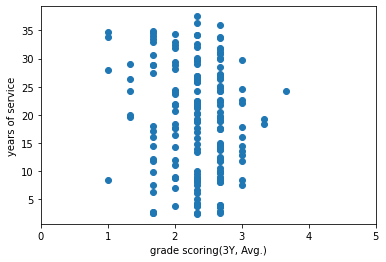

In [ ]:
plt.scatter(df5['3년_평균'], df5['근무기간_년'])
plt.ylabel('years of service')
plt.xlim([0,5])
plt.xlabel('grade scoring(3Y, Avg.)')
plt.show()

In [ ]:
df5.공장.unique()

array(['평택공장', '광주공장', '상하공장', '청양공장', '경산공장', '영동공장', '평택물류', '광주물류',
       '경산물류'], dtype=object)

In [ ]:
#### F.3년 미만 저평가자 비율

In [ ]:
df6 = df[['그룹입사일_근무년월', '19년','20년','21년']].copy()
df6['그룹입사일_근무년'] = df6['그룹입사일_근무년월'].str.split('년', expand=True)[0].astype('int')
df6['그룹입사일_근무월'] = df6['그룹입사일_근무년월'].str.split('년', expand=True)[1]
df6['그룹입사일_근무월'] = df6['그룹입사일_근무월'].str.split('개월', expand=True)[0].astype('int')

In [ ]:
df6['근무기간_년'] = df6['그룹입사일_근무년'] + df6['그룹입사일_근무월']/12

In [ ]:
df6['평가근거_구분']  = df4['평가근거_구분']

In [ ]:
df6.head()

,그룹입사일_근무년월,19년,20년,21년,그룹입사일_근무년,그룹입사일_근무월,근무기간_년,평가근거_구분
1,36년4개월,B,C,C,36,4,36.333333,개인태도
2,34년11개월,C,D,C,34,11,34.916667,개인태도
3,34년5개월,C,D,B,34,5,34.416667,직무역량
4,23년9개월,C,C,C,23,9,23.750000,개인태도
5,2년10개월,B,D,D,2,10,2.833333,개인태도


In [ ]:
print('- 3년 미만 근무자의 비율 : {}%'.format( round(len(df6[df6['근무기간_년'] <  3])/ len(df6)*100, 2) ))

- 3년 미만 근무자의 비율 : 12.04%


In [ ]:
df6[df6['근무기간_년'] <  3].groupby('평가근거_구분')['21년'].count()

평가근거_구분
개인태도     7
문제없음     6
직무역량    13
Name: 21년, dtype: int64